In [1]:
import os
from pathlib import Path
import shutil
import subprocess
import py3Dmol
from openff.toolkit.topology.molecule import FrozenMolecule, Molecule
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper, OpenEyeToolkitWrapper
from distutils.spawn import find_executable
import tempfile
from openff.toolkit.utils.utils import temporary_cd   # this is really cool btw
from simtk import unit
from rdkit import Chem
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button, RadioButtons
from PIL import Image
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean, median, pstdev, pvariance
from scipy import stats
from math import sqrt
import random
import ast
import re
from sqlalchemy import create_engine
from storage_structure import *
from MolDatabase import *

# Loading the Data

In [13]:
rd_confs = pd.read_csv("rd_confs.txt", index_col=0, sep='?', header=0) # tests on rdkit generated conformers
oe_confs = pd.read_csv("oe_confs.txt", index_col=0, sep='?', header=0) # tests on openeye generated conformers

In [351]:
engine = create_engine("sqlite:///example_database.db")
Session = sessionmaker(bind=engine) # define a session to work on the engine we just made
session = Session()

query = session.query(RDKitConformers.id,
                       RDKitConformers.conf_id,
                       RDKitConformers.name,
                       RDKitConformers.openeye_charges,
                       RDKitConformers.ante_charges)
rd_sql_confs = pd.read_sql(query.statement, engine)

query = session.query(OpenEyeConformers.id,
                       OpenEyeConformers.conf_id,
                       OpenEyeConformers.name,
                       OpenEyeConformers.openeye_charges,
                       OpenEyeConformers.ante_charges)
oe_sql_confs = pd.read_sql(query.statement, engine)

session.close()
engine.dispose()

rd_sql_confs.head()

,id,conf_id,name,openeye_charges,ante_charges
0,1,0,DrugBank_5354,"[-0.13346000015735626, -0.12031999975442886, -...","[-0.133, -0.1205, -0.1205, -0.096, -0.151, -0...."
1,2,1,DrugBank_5354,"[-0.13648000359535217, -0.12004999816417694, -...","[-0.136, -0.12, -0.12, -0.096, -0.163, -0.134,..."
2,3,2,DrugBank_5354,"[-0.1286199986934662, -0.1179099977016449, -0....","[-0.129, -0.118, -0.118, -0.092, -0.154, -0.13..."
3,4,3,DrugBank_5354,"[-0.13032999634742737, -0.1181500032544136, -0...","[-0.13, -0.118, -0.118, -0.088, -0.148, -0.141..."
4,5,4,DrugBank_5354,"[-0.13517999649047852, -0.11834000051021576, -...","[-0.135, -0.118, -0.118, -0.106, -0.13, -0.139..."


In [322]:
engine = create_engine("sqlite:///example_database.db")
Session = sessionmaker(bind=engine) # define a session to work on the engine we just made
session = Session()

query = session.query(Molecules.name, Molecules.molecule)
mols = pd.read_sql(query.statement, engine)

session.close()
engine.dispose()

In [323]:
rd_confs.dropna(inplace=True)
oe_confs.dropna(inplace=True)
rd_confs['ante_charges'] = rd_confs['ante_charges'].map(lambda x: eval(x) if "nan" not in x else np.nan)
rd_confs['oe_charges'] = rd_confs['oe_charges'].map(lambda x: eval(x) if "nan" not in x else np.nan)
oe_confs['ante_charges'] = oe_confs['ante_charges'].map(lambda x: eval(x) if "nan" not in x else np.nan)
oe_confs['oe_charges'] = oe_confs['oe_charges'].map(lambda x: eval(x) if "nan" not in x else np.nan)
rd_confs.dropna(inplace=True)
oe_confs.dropna(inplace=True)

TypeError: eval() arg 1 must be a string, bytes or code object

# Testing if both ELF selection methods are equivalent

In [17]:
# see how often the openeye and rdkit ELF1 selection agreed with eachother 
# for rdkit generated conformers:
num_agreed = len(rd_confs[(rd_confs["oe_selected"]==True) & (rd_confs["rd_selected"] == True)])
num_disagreed = len(rd_confs[(rd_confs["oe_selected"]==False) & (rd_confs["rd_selected"] == True)])
num_disagreed += len(rd_confs[(rd_confs["oe_selected"]==True) & (rd_confs["rd_selected"] == False)])
print(f"{num_agreed} times where openeneELF1 and rdkitELF1 agreed with conformers generated with rdkit, {num_disagreed} times where they disagreed")

# for openeye generated conformers:
num_agreed = len(oe_confs[(oe_confs["oe_selected"]==True) & (oe_confs["rd_selected"] == True)])
num_disagreed = len(oe_confs[(oe_confs["oe_selected"]==False) & (oe_confs["rd_selected"] == True)])
num_disagreed += len(oe_confs[(oe_confs["oe_selected"]==True) & (oe_confs["rd_selected"] == False)])
print(f"{num_agreed} times where openeneELF1 and rdkitELF1 agreed with conformers generated with openeye, {num_disagreed} times where they disagreed")

303 times where openeneELF1 and rdkitELF1 agreed with conformers generated with rdkit, 18 times where they disagreed
245 times where openeneELF1 and rdkitELF1 agreed with conformers generated with openeye, 0 times where they disagreed


# testing if ELF1 using rdkit generated conformers is similar to ELF1 using openeye generated conformers
Since each method generated different conformers, it is a bit difficult to do a one-to-one comparison between the methods. We will first see what the typical spread of data is for randomly selected conformers (no order in how they are selected). Then, we will look at how our ELF1 selection affects the consistency of the output charges


## plotting charges for randomly selected conformers

In [45]:
def scatter_charges(axis, x_data, y_data, atoms, names, confs, verbose=True, alpha=0.7, sample=-1, thresh=0.02):
#     x_data = x_data.to_list()
#     x_data = [re.split(' +', x.strip('][')) for x in x_data]
#     x_data = [[i for i in row if i] for row in x_data]
#     x_data = [list(map(float, row)) for row in x_data]

#     y_data = y_data.to_list()
#     y_data = [re.split(' +', x.strip('][')) for x in y_data]
#     y_data = [[i for i in row if i] for row in y_data]
#     y_data = [list(map(float, row)) for row in y_data]

    # stretch out the names column by the number of atoms in each molecule
    
    x = [item for row in x_data for item in row]
    y = [item for row in y_data for item in row]
    a = [a._atomic_number for atom in atoms for a in atom]
    names = [name for row in names for name in row]
    confs = [conf for row in confs for conf in row]
    # attempt to remove any nan entries
    df = pd.DataFrame(list(zip(x,y,a, names, confs)), columns=["x", "y", "a", "names", "confs"])
    df.dropna(inplace=True)
    # sample here
    if sample == -1:
        pass
    else:
        df = df[df['confs'] == sample]
    x = df["x"].tolist()
    y = df["y"].tolist()
    a = df["a"].tolist()
    names = df["names"].tolist()
    confs = df["confs"].tolist()
    assert(len(x) == len(y) == len(a) == len(names) == len(confs))
    n = len(x)
    
    color_map = {1: "black",
                 6: "black",
                 7: "blue",
                 8: "red",
                 17: "green",
                 16: "yellow",
                 15: "orange",
                }
    colors = [color_map.get(atomic_num, "magenta") for atomic_num in a]

    x = np.c_[x]
    y = np.array(y)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    line = regr.predict(x)
    m = regr.coef_[0]
    b = regr.intercept_
    m_squared_error = mean_squared_error(y, line)
    r2 = r2_score(y, line)

    axis.scatter(x, y, c=colors, s=5, alpha = alpha)
    axis.plot(x, line, c='r', linewidth=1)
    axis.plot(x, x, c='k', linewidth=0.7, alpha=alpha, linestyle='--')
    
    line_info = f'coeff of Determination: {r2:.8f} \n' + \
                f'root_mean_squared_error: {sqrt(m_squared_error):.5e} \n' + \
                f'intercept: {b:.4e} \n' + \
                f'slope: {m:.4e} \n' +\
                f'n: {len(x)}'
    
    axis.text(0.05, 0.95, line_info,
        verticalalignment='top', horizontalalignment='left',
        transform=axis.transAxes,
        color='black', fontsize=8)
    
    troublesome_mols = []
    for x_charge, y_charge, atom, name in zip(x, y, a, names):
        if abs(x_charge - y_charge) >= thresh:
            troublesome_mols.append(name)
    troublesome_mols = list(set(troublesome_mols))
    if verbose:
        print(f"A total of {len(troublesome_mols)} troublesome mols were found")
    for mol_name in troublesome_mols:
        atoms_different = set()
        for x_charge, y_charge, atom, name in zip(x, y, a, names):
            if name == mol_name:
                if abs(x_charge - y_charge) >= thresh:
                    atoms_different.add(atom)
        if verbose:
            print(f"atoms with significant deviations in {mol_name} -> {atoms_different}")
    return troublesome_mols
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

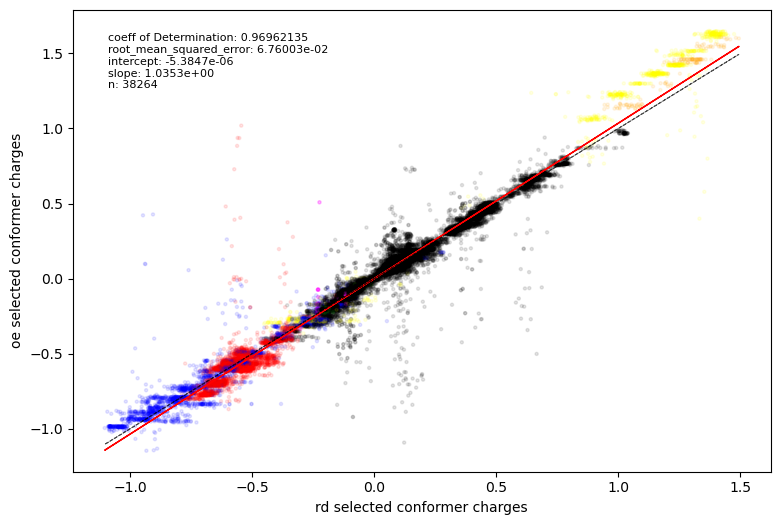

In [37]:
random_confs = pd.merge(rd_confs, oe_confs, how="left", left_on=['name', 'conf_id'], right_on=['name', 'conf_id'])
random_confs.dropna(inplace=True)
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)


df = random_confs
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
scatter_charges(axs, random_confs['ante_charges_x'], random_confs['ante_charges_y'], atoms, names, False)
axs.set(xlabel="rd selected conformer charges", ylabel="oe selected conformer charges")
axs.label_outer()

## plotting charges for only the ELF1 selected conformers 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

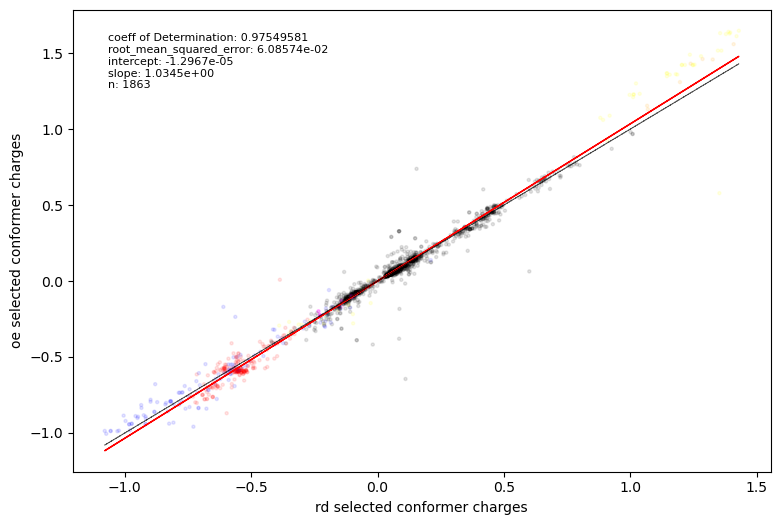

In [38]:
random_confs = pd.merge(rd_confs, oe_confs, how="left", left_on=['name', 'conf_id'], right_on=['name', 'conf_id'])
random_confs = random_confs[random_confs['oe_selected_x']==True]
random_confs.dropna(inplace=True)
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

df = random_confs
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
scatter_charges(axs, random_confs['ante_charges_x'], random_confs['ante_charges_y'], atoms, names, False)
axs.set(xlabel="rd selected conformer charges", ylabel="oe selected conformer charges")
axs.label_outer()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-0.03285949356537242, 0.2)

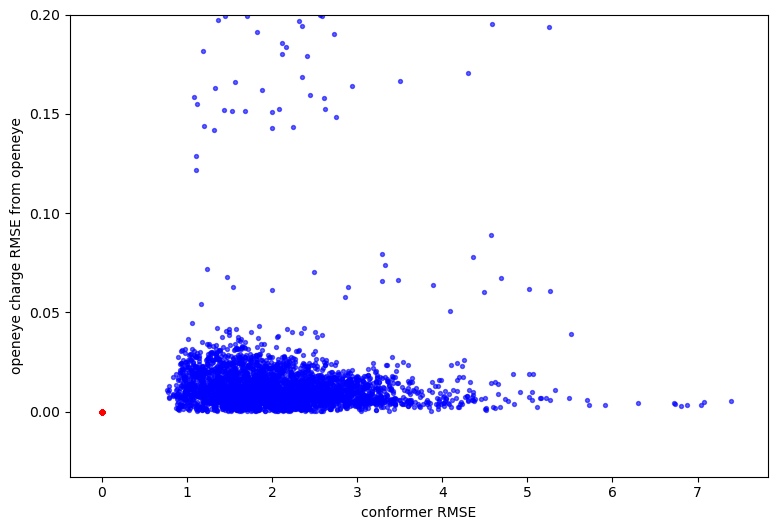

In [39]:
%matplotlib widget

fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axis = gs.subplots(sharex=True, sharey=True)

dframe = oe_confs
x = []
y = []
col = []
for name, row in dframe.iterrows():
    openeye_row = dframe[(dframe['name'] == row['name']) & (dframe['oe_selected'] == True)].iloc[0, :]
    openeye_charges = openeye_row['oe_charges']
    method1 = row['oe_charges']

    diff1 = [(i1 - i2) for i1, i2 in zip(method1, openeye_charges)]
    n = len(diff1)
    x.append(row['rmse'])
    y.append(sqrt(sum(l*l for l in diff1)/n))
    if row['oe_selected'] == True:
        col.append('red')
    else:
        col.append('blue')

for i in range(len(x)):
    axis.scatter(x[i], y[i], c=col[i], s=8, alpha=0.6)

axis.set(xlabel="conformer RMSE", ylabel="openeye charge RMSE from openeye")
axis.set_ylim(top=0.2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-0.023119140815571544, 0.2)

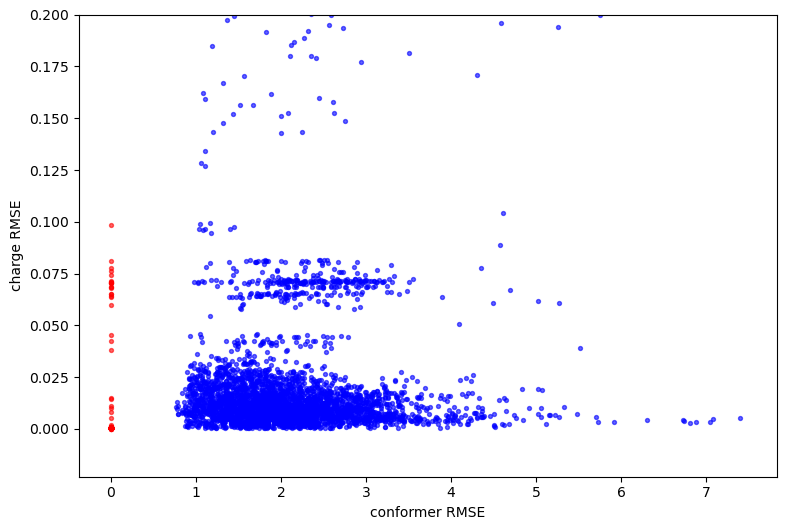

In [74]:
%matplotlib widget

fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axis = gs.subplots(sharex=True, sharey=True)

dframe = oe_confs
x = []
y = []
col = []
for name, row in dframe.iterrows():
    openeye_row = dframe[(dframe['name'] == row['name']) & (dframe['oe_selected'] == True)].iloc[0, :]
    openeye_charges = openeye_row['oe_charges']
    method1 = row['ante_charges']

    diff1 = [(i1 - i2) for i1, i2 in zip(method1, openeye_charges)]
    n = len(diff1)
    x.append(row['rmse'])
    y.append(sqrt(sum(l*l for l in diff1)/n))
    if row['oe_selected'] == True:
        col.append('red')
    else:
        col.append('blue')

for i in range(len(x)):
    axis.scatter(x[i], y[i], c=col[i], s=8, alpha=0.6)

axis.set(xlabel="conformer RMSE", ylabel="charge RMSE")
axis.set_ylim(top=0.2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A total of 9 troublesome mols were found
atoms with significant deviations in DrugBank_3332 -> {6, 7}
atoms with significant deviations in DrugBank_3011 -> {6, 7}
atoms with significant deviations in DrugBank_5904 -> {1, 6, 7}
atoms with significant deviations in DrugBank_556 -> {1, 6, 7}
atoms with significant deviations in DrugBank_5555 -> {1, 6, 7}
atoms with significant deviations in DrugBank_3028 -> {6, 7}
atoms with significant deviations in DrugBank_2982 -> {6, 7}
atoms with significant deviations in DrugBank_5711 -> {1, 6, 7}
atoms with significant deviations in DrugBank_3278 -> {8, 1, 6, 7}


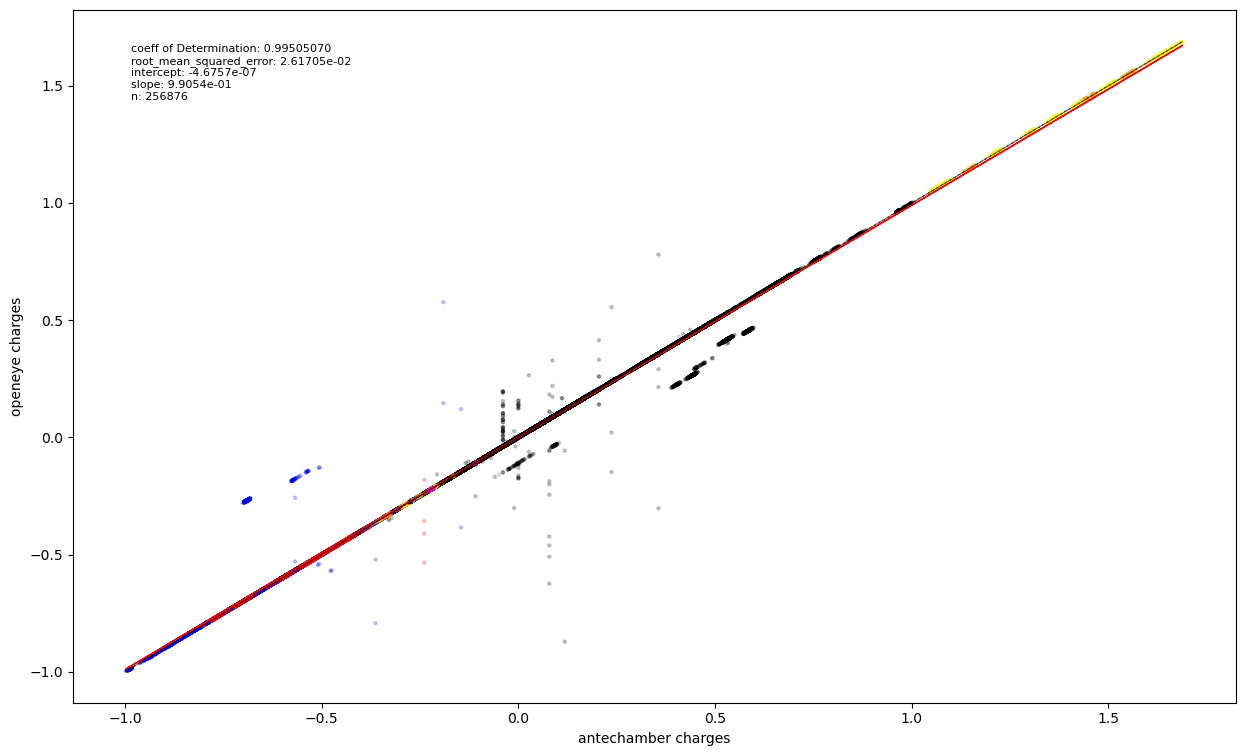

In [47]:
fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

df = oe_sql_confs
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
troublesome_mols = scatter_charges(axs, df['openeye_charges'], df['ante_charges'], atoms, names)
axs.set(xlabel="antechamber charges", ylabel="openeye charges")
axs.label_outer()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A total of 9 troublesome mols were found
atoms with significant deviations in DrugBank_3332 -> {6, 7}
atoms with significant deviations in DrugBank_3011 -> {6, 7}
atoms with significant deviations in DrugBank_5904 -> {1, 6, 7}
atoms with significant deviations in DrugBank_556 -> {1, 6, 7}
atoms with significant deviations in DrugBank_5555 -> {1, 6, 7}
atoms with significant deviations in DrugBank_3028 -> {6, 7}
atoms with significant deviations in DrugBank_2982 -> {6, 7}
atoms with significant deviations in DrugBank_5711 -> {1, 6, 7}
atoms with significant deviations in DrugBank_3278 -> {8, 1, 6, 7}


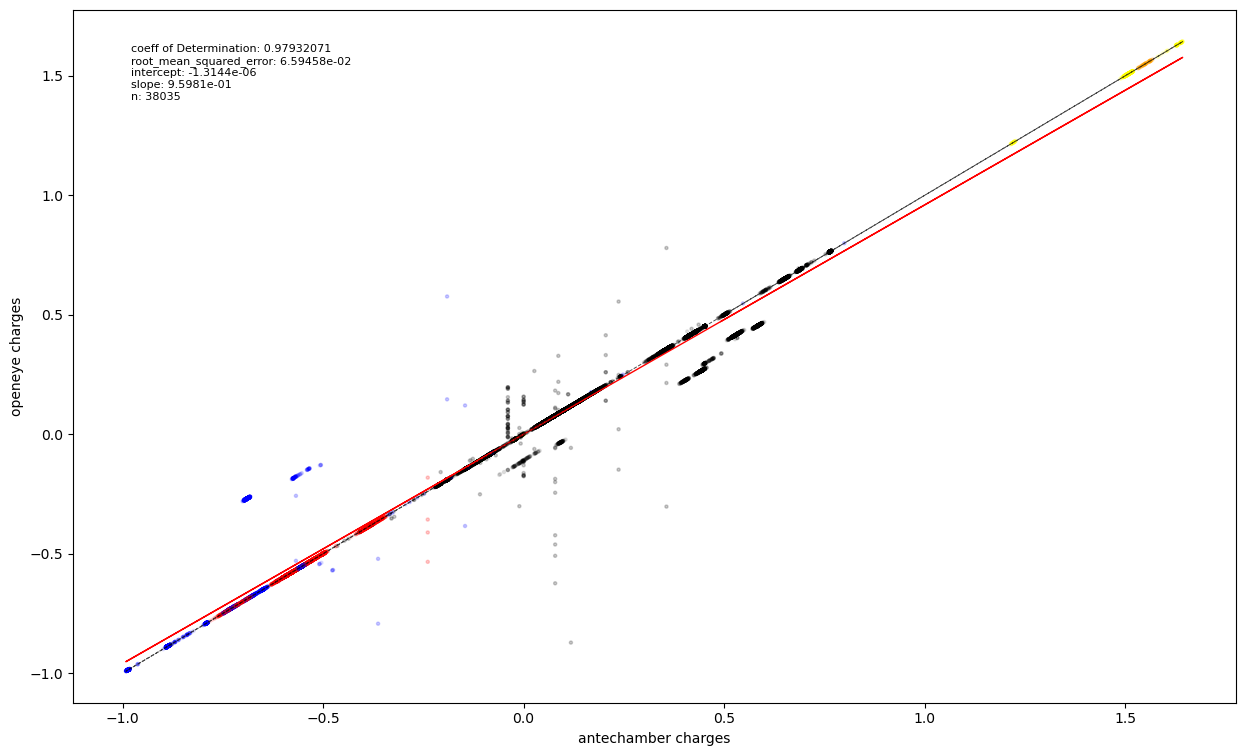

In [48]:
# only those troublesome mols
fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

df = oe_sql_confs[oe_sql_confs['name'].isin(troublesome_mols)]
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
openeye_troublesome_mols = scatter_charges(axs, df['openeye_charges'], df['ante_charges'], atoms, names)
axs.set(xlabel="antechamber charges", ylabel="openeye charges")
axs.label_outer()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A total of 0 troublesome mols were found


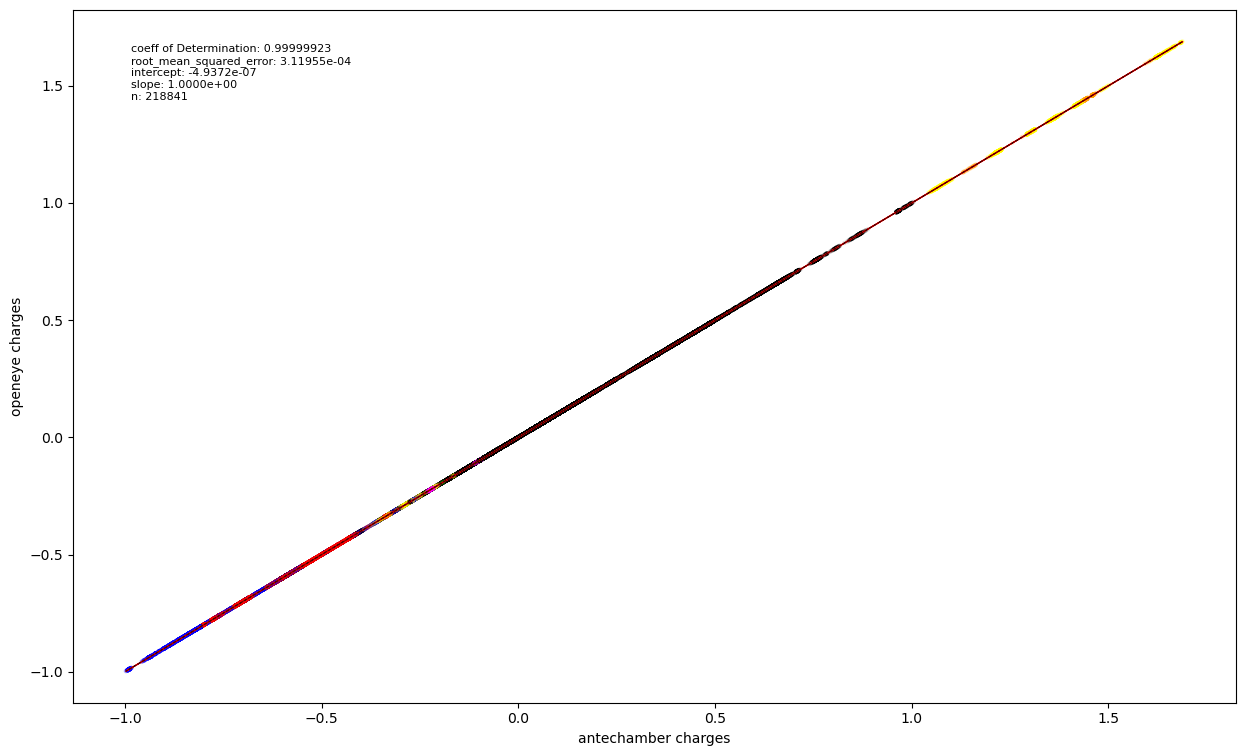

In [42]:
# all but those troublesome mols
fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

df = oe_sql_confs[~oe_sql_confs['name'].isin(troublesome_mols)]
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
troublesome_mols = scatter_charges(axs, df['openeye_charges'], df['ante_charges'], atoms, names)
axs.set(xlabel="antechamber charges", ylabel="openeye charges")
axs.label_outer()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A total of 10 troublesome mols were found
atoms with significant deviations in DrugBank_3332 -> {6, 7}
atoms with significant deviations in DrugBank_3011 -> {6, 7}
atoms with significant deviations in DrugBank_5904 -> {1, 6, 7}
atoms with significant deviations in DrugBank_556 -> {1, 6, 7}
atoms with significant deviations in DrugBank_5555 -> {1, 6, 7}
atoms with significant deviations in DrugBank_2982 -> {6, 7}
atoms with significant deviations in DrugBank_3028 -> {6, 7}
atoms with significant deviations in DrugBank_293 -> {1, 6, 7, 8, 16}
atoms with significant deviations in DrugBank_5711 -> {1, 6, 7}
atoms with significant deviations in DrugBank_5514 -> {1, 6, 7, 8, 9, 16}


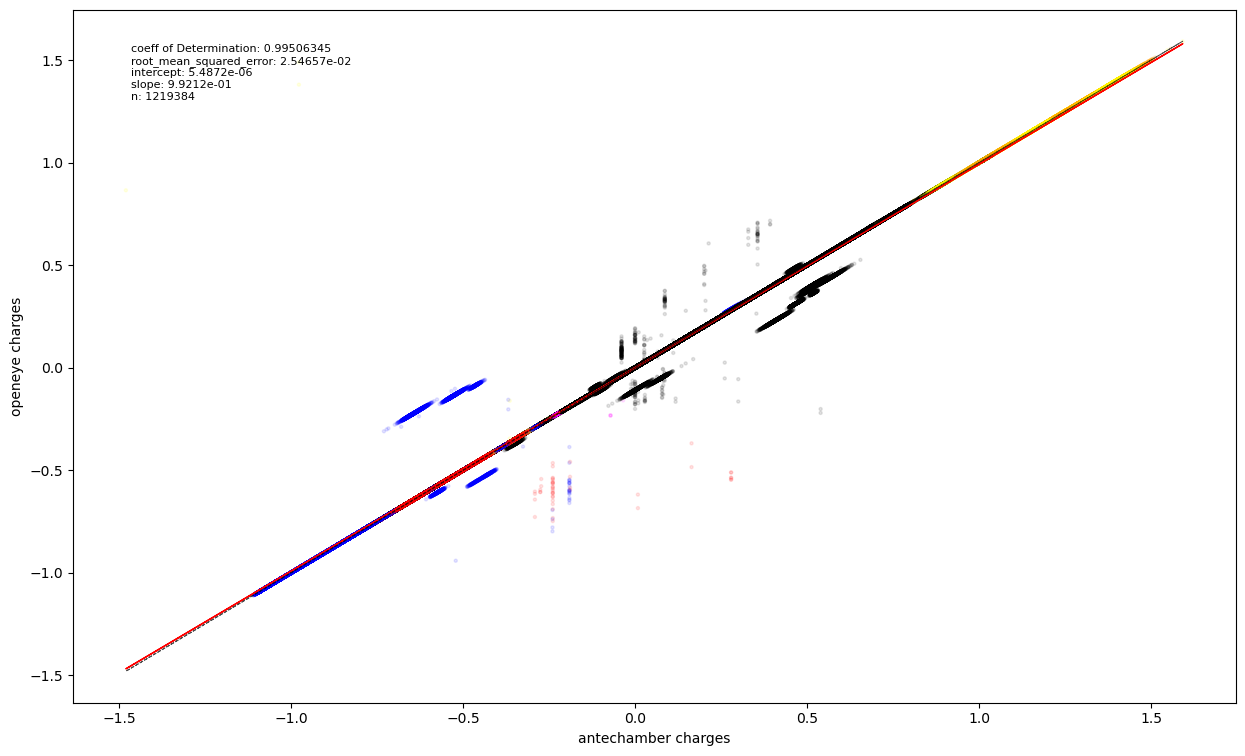

In [43]:
fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

df = rd_sql_confs
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
troublesome_mols = scatter_charges(axs, df['openeye_charges'], df['ante_charges'], atoms, names)
axs.set(xlabel="antechamber charges", ylabel="openeye charges")
axs.label_outer()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A total of 8 troublesome mols were found
atoms with significant deviations in DrugBank_3332 -> {6, 7}
atoms with significant deviations in DrugBank_3011 -> {6, 7}
atoms with significant deviations in DrugBank_5904 -> {1, 6, 7}
atoms with significant deviations in DrugBank_556 -> {1, 6, 7}
atoms with significant deviations in DrugBank_5555 -> {1, 6, 7}
atoms with significant deviations in DrugBank_3028 -> {6, 7}
atoms with significant deviations in DrugBank_2982 -> {6, 7}
atoms with significant deviations in DrugBank_5711 -> {1, 6, 7}


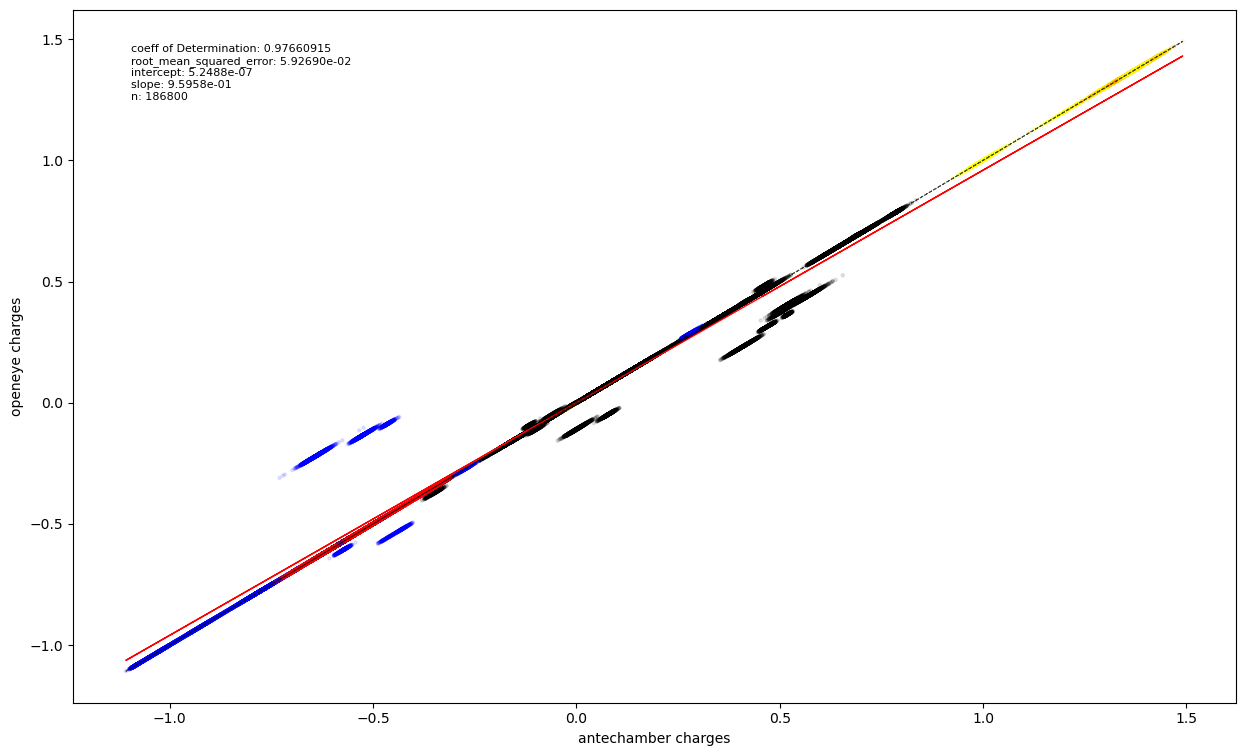

In [49]:
# only those troublesome mols
fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

df = rd_sql_confs[rd_sql_confs['name'].isin(troublesome_mols)]
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
rdkit_troublesome_mols = scatter_charges(axs, df['openeye_charges'], df['ante_charges'], atoms, names)
axs.set(xlabel="antechamber charges", ylabel="openeye charges")
axs.label_outer()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A total of 0 troublesome mols were found


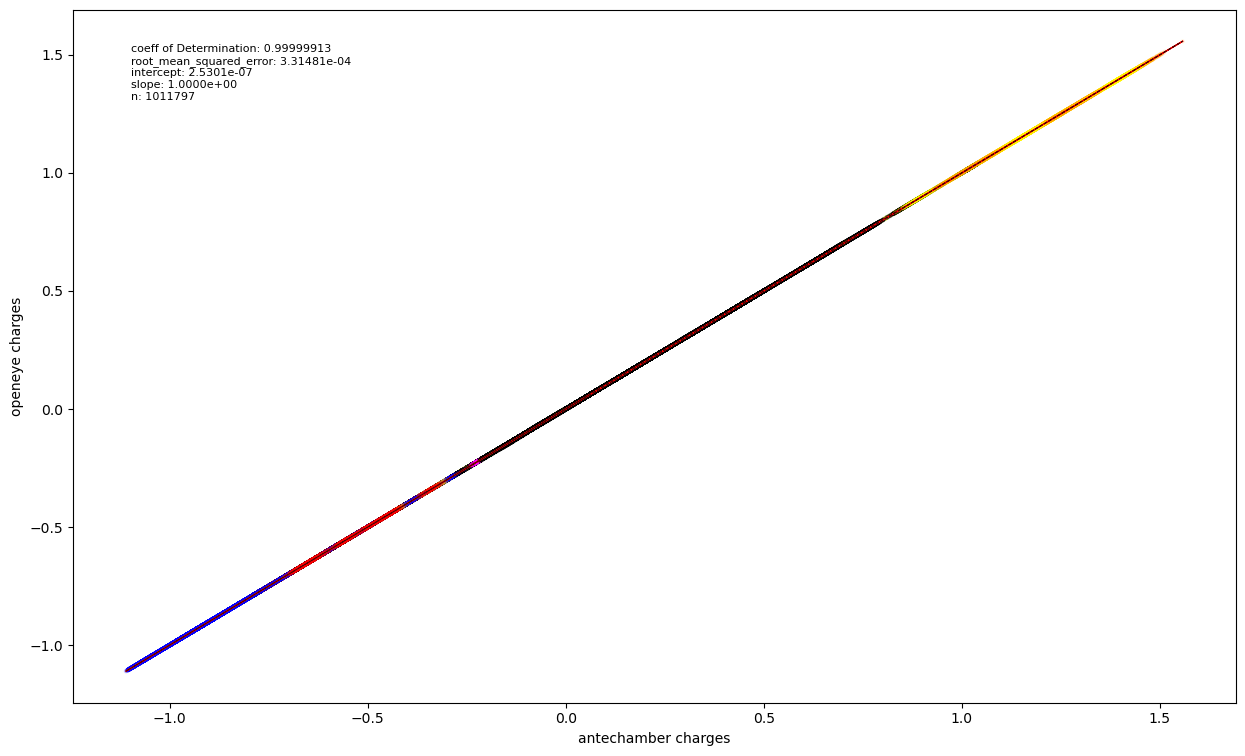

In [45]:
# all but those troublesome mols
fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

df = rd_sql_confs[~rd_sql_confs['name'].isin(troublesome_mols)]
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
troublesome_mols = scatter_charges(axs, df['openeye_charges'], df['ante_charges'], atoms, names)
axs.set(xlabel="antechamber charges", ylabel="openeye charges")
axs.label_outer()

In [101]:
for mol in select_mols.molecule:
    mol.to_file(f"troublesome_mols/{mol.name}.sdf", 'sdf')

# Test Cases to fix RDKit/Openeye Discrepancies

In [54]:
all_troublesome_mols = list(set([*openeye_troublesome_mols, *rdkit_troublesome_mols]))

In [55]:
all_troublesome_mols

['DrugBank_3332',
 'DrugBank_5904',
 'DrugBank_3011',
 'DrugBank_556',
 'DrugBank_5555',
 'DrugBank_3028',
 'DrugBank_2982',
 'DrugBank_5711',
 'DrugBank_3278']

## Validating the input/output of antechamber
I checked the intermediate files to try and catch any obvious errors and found that antechamber was applying all conditions as expected. 

## Symmetry Issues
Next, I suspected symmetry might have some impact, so I tried running openeye with and without allowing symmetry, and compared to antechamber. I left all antechamber symmetry alone (the -pl was left as -1 to allow for the maximum path-length search to determine equivalent charges) and compared the outputs. Generally, I found that running openeye with no symmetry more closely agreed with antechamber. 

In [318]:
# run the following simulations only on the first conformer of each molecule, just to 
# conserve time during the early stages of testing


row_list = []
for mol, status in MolDatabase(["MiniDrugBank.sdf"]):
    # RDKit generated conformers
    mols_generated = MolDatabase([]).generate_confs(mol, n_conformers=20, method='rdkit')
    
    if mols_generated:
        original_mol = deepcopy(mol)
        mol_copy1 = Molecule(mol)
        mol_copy2 = Molecule(mol)
        # output the charges for each conformer and indicate if that conformer was selected or not
        conformers = original_mol.conformers
        for conf, conf_id in zip(conformers, range(0, len(conformers))):
            mol_copy = deepcopy(mol)
            mol_copy._conformers = [conf]

            ante_charges = MolDatabase([]).assign_mol_partial_charges(mol_copy, method="ante-am1-mullikennosymspt")
            oe_charges_nosym_noopt = MolDatabase([]).assign_mol_partial_charges(mol_copy, method="openeye-mullikennosymspt")
            oe_charges_noopt = MolDatabase([]).assign_mol_partial_charges(mol_copy, method="openeye-mullikennoopt")

            diff_nosym_noopt_list = [(a-b)**2 for a, b in zip(ante_charges, oe_charges_nosym_noopt)]
            diff_noopt_list = [(a-b)**2 for a, b in zip(ante_charges, oe_charges_noopt)]

            diff_nosym_noopt = sum(diff_nosym_noopt_list)
            diff_noopt = sum(diff_noopt_list)

            print(f"{diff_nosym_noopt}\t\t{diff_noopt}")
            row={'conf_id':conf_id, 
                      'name':mol.name, 
                      'am1_oe_charges_nosym_noopt':oe_charges_nosym_noopt, 
                      'am1_oe_charges_noopt':oe_charges_noopt, 
                      'am1_ante_charges':ante_charges, 
                      'diff_nosym_noopt':diff_nosym_noopt, 
                      'diff_noopt':diff_noopt}
            row_list.append(row)
            break
    else:
        print("some problem with conformer generation")
charge_methods_df = pd.DataFrame(row_list)

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): DrugBank_2987
Problematic atoms are:
Atom atomic num: 7, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 28, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): DrugBank_3502
Problematic atoms are:
Atom atomic num: 7, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic n

4.8467830017063945e-06		0.004815982962000565
4.256045900217979e-06		0.00025734215237167884
2.1360538138566225e-06		0.001577955143879579


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_2799Undefined chiral centers are:
 - Atom N (index 21)



8.210365267920918e-06		0.006962638337570039
7.870304864864482e-06		0.002459801058797954
8.117177877627148e-06		0.012149606054254074
9.894126862286263e-06		0.0033607740938312912
6.427243176708369e-06		0.0012796210473566866
2.724748620844412e-06		0.0016179348579120258


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_5415Undefined chiral centers are:
 - Atom N (index 12)



3.2762242910619035e-06		0.0002873457417335312
3.6809345291013966e-06		0.00402089878510474
4.96481146009739e-06		0.0010762955375489191
9.416714008039519e-06		0.008347092620311901
3.839923182259316e-06		0.0039072798585351575
6.797031829663687e-06		0.0014246983637835075
8.114255848609965e-06		0.006623470953495667
1.0835909545042295e-06		0.0012060175814671103
4.2539151127994295e-06		0.006830301176984175
4.312980662012673e-06		0.0015196035720906871
5.436883867781759e-06		0.005746148917934179
7.808116049792326e-06		0.007634048678608254
2.449128037215305e-06		0.0003903524058102574
5.736083891955877e-06		0.004790556270883071
4.128489743001472e-06		0.004461740585261111
6.624637530743827e-06		0.002990330109081579
1.1351006549413606e-06		1.124800802184449e-06
1.3853064911493074e-05		0.002262923388786715
5.62713293683241e-06		0.001685869608820058
1.3887161466728733e-06		0.0006053374006143532
3.2423306546652053e-06		0.0031044669969822127
8.96975590323979e-06		0.0012629777743946083
5.291583135549738

RDKit ERROR: [08:54:04] Explicit valence for atom # 3 N, 5, is greater than permitted


1.9303557893850495e-06		0.0014712019867330352
2.9169863699591528e-06		0.0022055871263596443
1.7859222301882837e-06		0.005850318167903869
2.707356683830289e-06		0.0002820393933778867
5.3710980878399234e-06		0.001941624435238872
5.8271981110533405e-06		0.005276083801154164
7.209545894558088e-06		0.004411857078145361
3.2472370133473863e-06		0.0037760239823233623
2.0109484288778662e-06		3.251340961653335e-05
5.163324859194343e-07		0.0009376013795377049
4.286352369049241e-06		0.005023915807019223
3.357064694515696e-06		0.00013308522446127006
1.6409731976042696e-06		0.0009478243908269019
7.5873484564995925e-06		0.0018903102599228138
4.0596923462522365e-06		0.0005253428160968413
7.028114258769548e-06		0.0004939981926457914


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_472Undefined chiral centers are:
 - Atom N (index 16)



4.948886764357526e-06		0.006626293577186074
2.811924645067538e-06		0.002233757483402675
3.8010581737467825e-06		0.0031855925836384784
1.6781613775090772e-06		0.0002805989592250565
3.15155167333311e-06		0.009709526791054005
1.3009965514393433e-06		0.0016681860038626137
5.165230693328311e-06		0.005873280090860387
4.667622308758544e-06		0.003560871413086046
1.1916121585727503e-05		0.012902961416472104
2.556338891250838e-06		0.002080841067323488
7.219263855961473e-06		0.005412800226444002
2.5566763156354816e-06		0.00011553223346153327
2.467601092772303e-06		0.0010594221558261332
4.6284732299609055e-06		0.0005812471053364955
4.556945438275691e-06		0.00011473241401166941
6.0563687163869464e-06		0.0014792689888040143
5.827518150400483e-06		0.0018206149841356292
4.476532710315349e-06		0.0015122772157292784
7.31939403309225e-07		0.00015944342494410364
7.327055212865918e-06		0.01372910345718937
3.227536639338151e-06		0.00343510779079227
7.758415182189756e-06		0.00803737709820335
4.36384530540410

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_794Undefined chiral centers are:
 - Atom N (index 10)



5.823958544984032e-06		0.0018303201834360494
4.528736612774188e-06		0.0012850040434569888
5.003849810327053e-06		0.00506154649907804
9.752388560155555e-06		0.0019395932474155515
5.613183691659364e-06		0.0026021990165397907
5.0566763749556635e-06		0.003717451676233953
9.227922634669037e-06		0.006956549194703762
9.57508086315388e-06		0.0020306692142444175
7.5600674850439605e-06		0.002632584238416605
7.431085873040314e-06		0.010120730283288866
2.7547256441253633e-06		0.0010835090181815507
2.415244615942603e-06		0.0007737514013236085
7.182946673581853e-06		0.003585120124019615
7.5276826871841775e-06		0.004076552677111714
5.168554920269002e-06		0.006006816165139557
5.78435306619976e-06		5.567880754240943e-05
4.816511934045772e-06		0.003444259687489659
2.509473491653678e-06		0.03299507870617368
3.1209599473272507e-06		0.0006923712092977017
2.6099080425499966e-06		0.0034649072564171043
9.709911236818457e-06		0.0033101328760815735
3.0476867886953586e-06		0.0003515952037717905
2.757271122538466

RDKit ERROR: [08:59:10] Explicit valence for atom # 4 N, 5, is greater than permitted


3.4399769344506157e-06		0.0005125865844912101
6.215012506075375e-06		0.002709904299143575
6.121524057990164e-06		0.006373905605486656
2.4019478522090445e-06		3.46955925671174e-05
2.067765590719045e-06		0.001637753798487053
6.146118279277613e-06		0.0010862089637499123
9.947306415033542e-06		0.0014509515679937835
2.950829798458909e-06		0.005468438811457647
3.30904943915202e-06		0.0007856253393547255


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_3739Undefined chiral centers are:
 - Atom N (index 16)
 - Atom N (index 17)



4.149555710028641e-06		0.0035985314269503135
2.4048245297100467e-06		0.00034029333678213677
2.0814109471785085e-06		0.0004998769951076232
5.290416406065099e-06		0.0030425011935454067
4.08465346287626e-06		0.008750476268274035
9.15980848327433e-06		0.00428441655262571
3.7866240190821883e-06		0.002407214389249392
2.9195429494368187e-06		0.00045252340866976294
2.3970908310472163e-06		2.584432704540224e-06
6.34806043578759e-06		0.0060356439098911705
3.355688598618499e-06		0.0005941988871710867
4.209610003192248e-06		0.00018673157437962512
1.7593072070732677e-06		0.00036304860806072063
1.1913530336957786e-05		0.010208713824897893
5.526036503156062e-06		0.0013076979676686464
3.840989836773686e-06		0.0016236395849381585
4.3914592869433865e-06		0.0020726185975911754
5.8511481378412666e-06		0.001443879845953536
6.581235188795632e-06		0.004344949864967392
7.153184268424601e-06		0.004256782378513088
2.0890321930945924e-06		2.1474120743900137e-06
5.960742211540081e-06		0.008809876911657528
7.25640

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_6353Undefined chiral centers are:
 - Atom N (index 18)



6.443717743752642e-06		0.005557061443572789
5.22036541587013e-06		0.004402895184663571
4.826353477103989e-06		0.001837809084966512
9.633232402994705e-06		0.002052055884463013
5.080128065547334e-06		0.0009726579954613192
6.897965294716289e-06		0.017361814370053442
3.4265795050723244e-06		0.0028713085818357965
5.9284872838522115e-06		0.0026537087151571642
4.0987386965463346e-06		0.005812881836420307
2.2243135976795336e-06		0.0021541132577099693
8.977861186589667e-06		0.002624093718345854
3.7279257232281006e-06		0.0009409122052171013
1.8365083439816214e-06		0.00014625059826630775
2.1758925940250046e-06		0.003195049995174683
8.342639761710977e-06		0.030101834942538853
5.130802020361841e-06		0.0018933517765869217
5.731365620541807e-06		0.0034907185066824554
1.500707725291731e-06		0.0023539491915970188
8.116250557430148e-07		0.0003457827980813899
3.3948913728608954e-06		0.0006858937731247202
4.807194363506965e-06		0.0067527847908007265
4.446430457121622e-06		0.0031886831748742174
3.055015569

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_1570Undefined chiral centers are:
 - Atom N (index 6)



3.849230708345056e-06		0.0018382378022611923
2.4005542760920548e-06		0.0004524653892146426
3.2160656130046473e-06		0.0020445371905517774
4.926776236640799e-06		0.0015131957312544688
1.5764278599755123e-05		0.010493063425569688
	RDKit also could not generate conformers for DrugBank_1594. Continuing with single conformer
no new conformers generated for DrugBank_1594
some problem with conformer generation


RDKit ERROR: [09:04:26] Explicit valence for atom # 5 N, 5, is greater than permitted


8.404318719397938e-06		0.0060123665736144544
2.9646120817534723e-06		0.0010894390556449843
3.8092788076936463e-06		0.0038981176887231623
4.4991905267003605e-06		0.0008388338006827431
3.380253201548032e-06		0.0023164281295234334
3.893422579213833e-06		0.0018186596004458745
1.6559622001846252e-06		0.0013947006591389546
5.937226097972907e-06		0.001785213634107923
4.240512324446125e-06		0.002208271901522379
4.533071793404933e-06		0.0016166072193252033
1.229330437938005e-05		0.0021632407258976045
	RDKit also could not generate conformers for DrugBank_1659. Continuing with single conformer
no new conformers generated for DrugBank_1659
some problem with conformer generation
	RDKit also could not generate conformers for DrugBank_1661. Continuing with single conformer
no new conformers generated for DrugBank_1661
some problem with conformer generation


RDKit ERROR: [09:05:13] Explicit valence for atom # 28 N, 5, is greater than permitted
RDKit ERROR: [09:05:14] Explicit valence for atom # 7 N, 5, is greater than permitted


8.216028001546835e-06		0.002945040999825572
7.908646885549052e-07		0.00020310681595109403
2.97817989526421e-06		0.0013138554221563546
4.405712993714721e-06		0.003648679989173677
5.561028762795009e-06		0.0007977487948244336
4.624006452218997e-06		0.0015343892351118453
6.989170697539736e-06		0.005008335333295947
4.197546274574612e-06		0.004223009399942133
4.707776443352783e-06		0.0016974990667200983
1.4851211428955241e-06		0.0050944649108419565
2.1114859477322667e-05		0.028041157977457463
3.5506293067734903e-06		0.0007312980984409645
7.4047491356482805e-06		0.0058666086727988944
	RDKit also could not generate conformers for DrugBank_4346. Continuing with single conformer
no new conformers generated for DrugBank_4346
some problem with conformer generation


RDKit ERROR: [09:06:31] Explicit valence for atom # 35 O, 3, is greater than permitted


1.3366916625789784e-06		6.17989927561081e-05
4.1099678396026186e-06		0.0035149527140038274
3.3675462383036268e-06		0.0005555914179625988
2.6358611173383426e-06		0.0025626785668843703
5.693999369610402e-06		0.0028096554183199146
7.258940634705854e-06		0.0035883503166174585
1.0190906961505124e-05		0.0031275912415970305
5.2322544533093065e-06		0.0017470840375942893
6.311326594188726e-06		0.013122938376578576
1.1232872388908526e-05		0.0049939061630733285
6.051785197597453e-06		0.0007858487532828659
5.9739249316568635e-06		0.0017867770191961302
5.97538304884775e-06		0.0035008201944071913


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_1802Undefined chiral centers are:
 - Atom N (index 36)



1.4602267803170487e-05		0.004821812329950188
5.060113970778474e-06		0.003279770600628918
9.053079108610865e-06		0.0002477163784375661
7.023810409114777e-06		0.0024515860156741343
1.0862980405681263e-05		0.026084160352110777
7.866399141759351e-06		0.005960717799047529
4.8467140226120405e-06		0.00391715741291578
3.817382714509683e-06		0.0019608142059141243


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_6865Undefined chiral centers are:
 - Atom N (index 7)



6.136940426115847e-06		0.006766669881135809
3.991872624409463e-06		0.000829430247705954
4.66616019218705e-06		0.004560379616396744
8.566124423063214e-06		0.0029572730056460065
1.716137247142394e-06		0.00027854286058889155
2.2544973528566314e-06		0.0017145257634541499
5.157259831230511e-06		0.0023388579903135948
2.182008259703322e-06		0.0004003073886784886
	RDKit also could not generate conformers for DrugBank_4545. Continuing with single conformer
some problem with conformer generation
1.57251606486569e-06		0.0010862392054834774
4.813436643699874e-06		0.004647710121926322
1.5084740057103943e-05		0.012921045760440732
7.570682375026744e-06		0.0032267623115722357
7.799159468192284e-06		0.0022897805284961817
3.106148464869195e-06		0.006598770395037117
5.319629032055043e-06		0.00045033881346596185
	RDKit also could not generate conformers for DrugBank_6947. Continuing with single conformer
no new conformers generated for DrugBank_6947
some problem with conformer generation


RDKit ERROR: [09:19:15] Explicit valence for atom # 6 N, 5, is greater than permitted


4.8073293621777966e-06		0.0015969954074140946
8.4936882013937e-06		0.001762787336728205
4.336485589203158e-06		0.0025595031757965304
5.000858876437904e-06		0.004320231199990474
7.1574911466092745e-06		0.008564812545773706
2.7788874610519675e-06		0.0022501721977002008
5.770445851022556e-06		0.0006923639707681587
2.5642626346792153e-06		0.0038938091310806258
3.6804985179466328e-06		2.1911400074360712e-05
1.7107013817581938e-06		0.0001866407930706741
4.2268403512433545e-06		0.006460783187093391
2.693432932397724e-06		0.0007176228064220602
2.8149438045459204e-06		0.001779309419059808
7.047534325906359e-06		0.0007459742257458875
1.2039240597323446e-05		0.0004935626506082428
5.430635994058912e-06		0.0024247536563864677
	RDKit also could not generate conformers for DrugBank_7049. Continuing with single conformer
no new conformers generated for DrugBank_7049
some problem with conformer generation


RDKit ERROR: [09:20:31] Explicit valence for atom # 11 N, 5, is greater than permitted


4.217139965459381e-06		0.00236157379431063
1.7584677544339967e-06		0.003559091194481048
1.0204035473978406e-06		1.3508602510167509e-05
5.432979365806999e-06		0.0028443819942833306
3.3756692749559104e-06		0.0016476592291934712
9.933937745601702e-06		0.006100371636690431
1.925233862460883e-06		0.010369819383367033
6.268108632393756e-06		0.003669020873769993
9.192656755031761e-06		0.005911935670685547
3.2694851462114435e-06		0.0005858688788009047
1.0070581638090854e-05		0.005093888588383
8.852255397249157e-06		0.01169540681669793
2.0076859892461246e-06		6.425387611618904e-06


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_7124Undefined chiral centers are:
 - Atom N (index 43)



1.1400627579892231e-05		0.005370768538462378
6.8083372290609135e-06		0.00039475397613229405
1.114634641464551e-05		0.013423959968868276
2.5522231886163792e-06		0.006043912639449033
8.764342386173391e-06		0.004788274711088971
3.583366623323387e-06		0.0007944016147127847
4.281720191762179e-06		0.004162167161407035
5.148200584144241e-06		0.0027072461269056305
4.4000312248067065e-06		0.0007268297975991689
1.274201476512145e-06		5.9151237887325646e-05
1.0564297735974849e-05		0.009244083400311054
6.597522274559376e-06		0.007549968194500552
3.830718118977287e-06		0.001953507616442596
6.27273313458081e-06		0.0018258275408301822


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_4865Undefined chiral centers are:
 - Atom N (index 10)



4.578981927023678e-06		0.0023417870027628213
3.6680586182173356e-06		0.0011116344014455604
1.8079277413684206e-06		0.003146071773749624


RDKit ERROR: [09:22:50] UFFTYPER: Unrecognized atom type: S_5+4 (19)


4.761427431457911e-06		0.012169872008537842
2.9891135396703876e-06		0.0010298297964884625
5.1928455583343645e-06		0.002058214792922083
1.0142096493352317e-05		0.0035561020564525156
5.513344028538143e-06		2.9903249080237794e-05
3.426118549059258e-06		0.0027851574026547333
6.098461173479326e-06		0.0020523615979405043
6.964121962034545e-06		0.004168556983173342
9.905200667460536e-06		0.002954247399641686
8.21829716795728e-06		0.006451209408185362
7.164792698065589e-06		0.004867659614197635
7.593142592188445e-06		0.0001351597311312697
3.840168332391126e-06		0.0019637522023916907
1.067950944691494e-05		0.0008121918889051338
6.963750647716062e-06		0.009285070822691184
3.1082806479503732e-06		0.0012904884419629237
6.111458233115923e-06		0.00017994660596330032
8.380854423169169e-06		0.006847108597567269
7.856734197174247e-06		0.004578901123686615
1.3406135347482215e-05		0.0006262194517710932


RDKit ERROR: [09:24:23] UFFTYPER: Unrecognized atom type: S_5+4 (12)


3.850409155115616e-06		0.003600041797179629
2.920444664938817e-06		0.011729736525377232
1.2378367033400972e-05		0.005871440339170291
7.659138916807784e-06		0.002329032970968801
1.7938500110419596e-06		0.0007744224584480957


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: DrugBank_2465Undefined chiral centers are:
 - Atom N (index 7)



6.929698935500221e-06		0.002932470879023995
1.3768884484759962e-06		1.3285699466721182e-06
3.933877169172695e-06		0.0005542133847319783
4.441258992206524e-06		0.0018875884432224526
3.060241750640854e-06		0.0005548936405520068
1.7748732776776413e-06		0.003006181841303899
1.623748402353296e-06		0.0007462088349422878
3.446524857694537e-06		0.00024381999108827502
7.279410738100191e-06		0.007530011992532645
7.512970612510825e-06		0.0006477867802723631
7.2627212659668046e-06		0.0010574571992767357
4.648568083086387e-06		0.0019185659456625087


RDKit ERROR: [09:25:27] UFFTYPER: Unrecognized atom type: S_5+4 (30)


5.967785977576593e-06		0.007266705818221366
6.1535754129756075e-06		0.001803929229306648
2.2794127364645965e-06		0.0009530749311824706
3.0630000275477376e-06		0.0028538844223658937
4.046475555251672e-06		0.0015010451985507883
3.157140332340391e-06		0.008459241623651624
1.8534139814952215e-06		0.00018336701563156734
8.300418599501487e-06		0.0034114043159664295
6.2841285773358895e-06		0.0016280169322913567
8.787431502834887e-06		0.004993648576748997
4.49823942077523e-06		0.0006090362249833149
4.252038892460061e-06		0.002011975564384024
6.392523959814553e-06		0.001799005400452279
4.353887308743978e-06		0.002502572008819271
1.2628325325910321e-06		4.5014025145556576e-05
4.141448121388809e-06		0.002047437834810763
9.7005566278208e-06		0.003921917993695069
5.028177894832084e-06		0.0024842509051896285
2.423890889304224e-06		0.0003527935874328753
8.449392315582949e-06		0.0033473959824274714
4.057344364772638e-06		0.001697206514271681
5.174759216088449e-06		0.0032683083701879577
2.7947352091686

RDKit WARNING: [09:27:13] UFFTYPER: Warning: hybridization set to SP3 for atom 26


9.382985124628894e-06		0.002098020154286059


In [325]:
charge_methods_df.columns = ['conf_id', 'name', 'am1_oe_charges_nosym_noopt', 'am1_oe_charges_noopt',
       'am1_ante_charges', 'diff_nosym_noopt', 'diff_noopt']

## original plot of bcc charges for RDkit conformers

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A total of 9 troublesome mols were found
atoms with significant deviations in DrugBank_3332 -> {6, 7}
atoms with significant deviations in DrugBank_3011 -> {6, 7}
atoms with significant deviations in DrugBank_5904 -> {1, 6, 7}
atoms with significant deviations in DrugBank_556 -> {1, 6, 7}
atoms with significant deviations in DrugBank_5555 -> {1, 6, 7}
atoms with significant deviations in DrugBank_3028 -> {6, 7}
atoms with significant deviations in DrugBank_2982 -> {6, 7}
atoms with significant deviations in DrugBank_5711 -> {1, 6, 7}
atoms with significant deviations in DrugBank_3278 -> {8, 1, 6, 7}


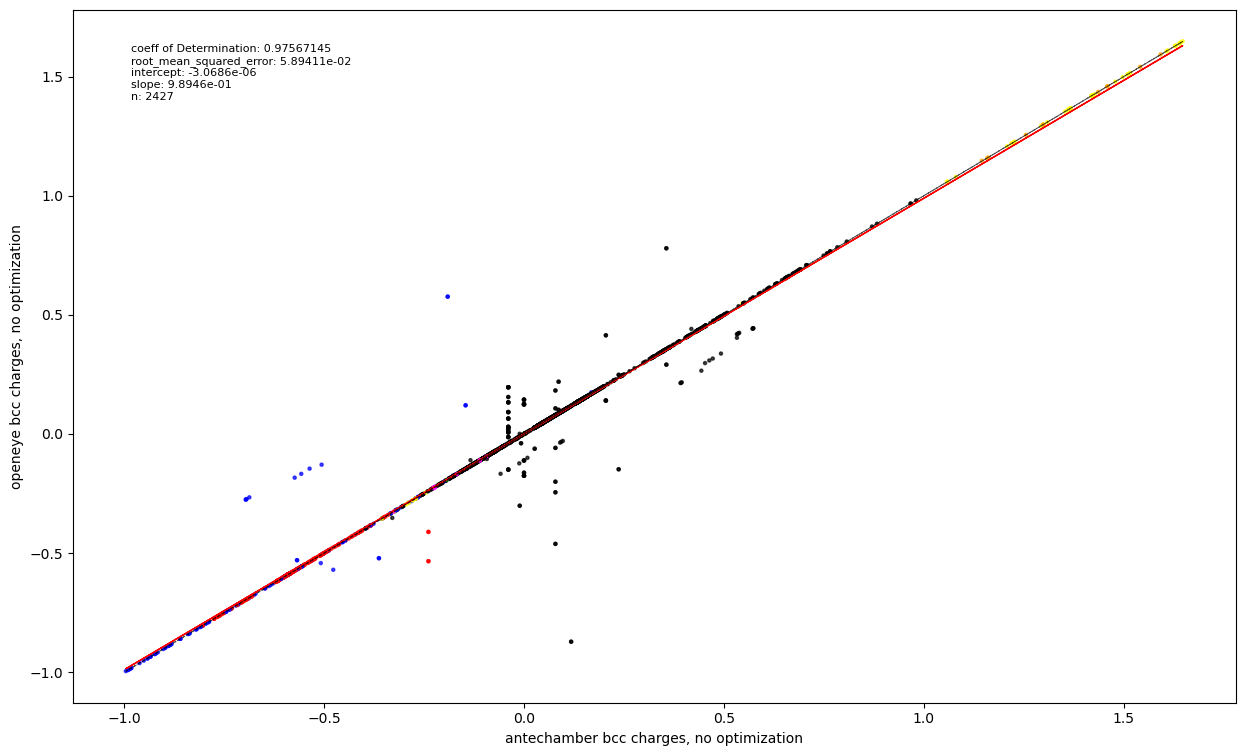

In [331]:
fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

df = oe_sql_confs[oe_sql_confs["conf_id"] == 0]
df = mols.merge(df, how="inner")
df = charge_methods_df.merge(df, how="inner", on=['name', 'conf_id'])
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
troublesome_mols = scatter_charges(axs, df['openeye_charges'], df['ante_charges'], atoms, names)
axs.set(xlabel="antechamber bcc charges, no optimization", ylabel="openeye bcc charges, no optimization")
axs.label_outer()

## New plot of AM1 Muliken charges without symmetry or optimization

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A total of 0 troublesome mols were found


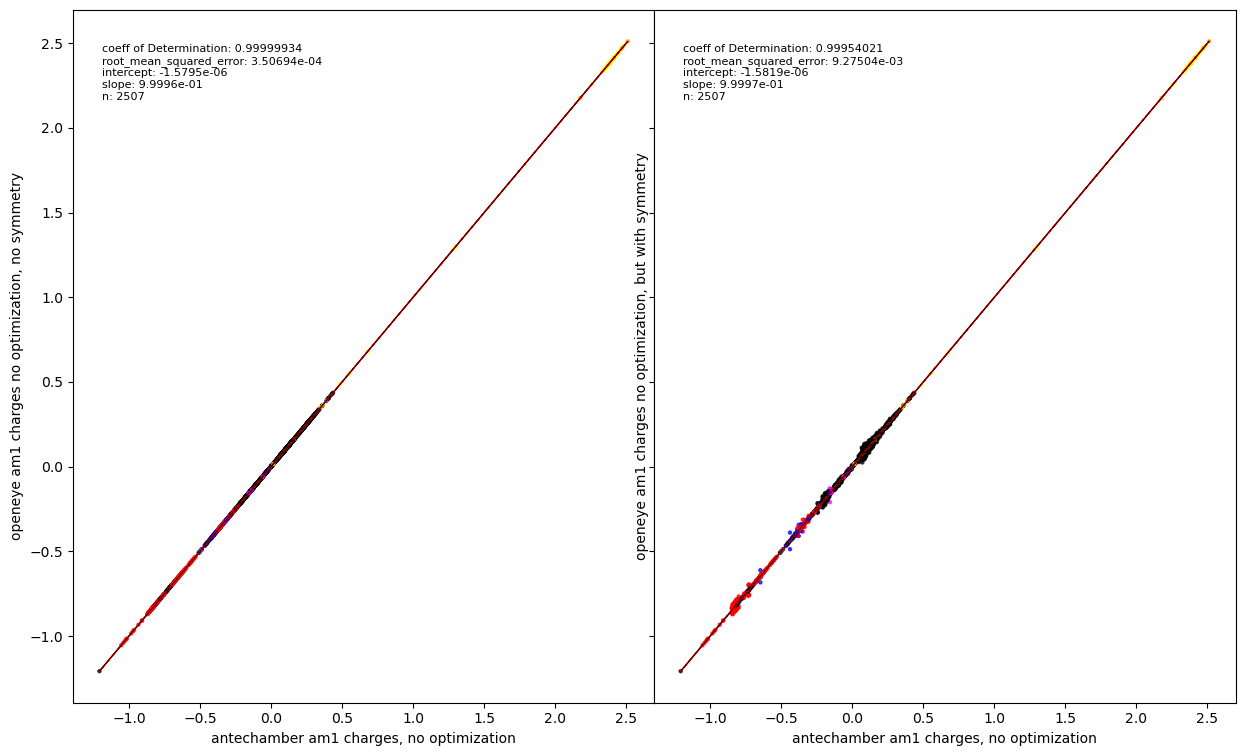

In [334]:
fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

troublesome_mols = scatter_charges(axs[0], df['am1_oe_charges_nosym_noopt'], df['am1_ante_charges'], atoms, names)
axs[0].set(xlabel="antechamber am1 charges, no optimization", ylabel="openeye am1 charges no optimization, no symmetry")
troublesome_mols = scatter_charges(axs[1], df['am1_oe_charges_noopt'], df['am1_ante_charges'], atoms, names, verbose=False)
axs[1].set(xlabel="antechamber am1 charges, no optimization", ylabel="openeye am1 charges no optimization, but with symmetry")
plt.show()

## Now Considering BCCs
Taking away symmetrization from the am1 muliken charges doesn't explain all the differences seen in the very first plot, although it does help in a minor way. We can now move on to analyzing the effects of BCCs and how each toolkit is applying BCCs. We can reverse engineering the BCCs be subtracting the BCC charges from the AM1 charges. In the case of openeye, I use the symmitrized charges since these are what was used to make the first plot. The same linear plot is useful: if we get a straight line, then both toolkits are assigning bccs in the same way, else, they are not. 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

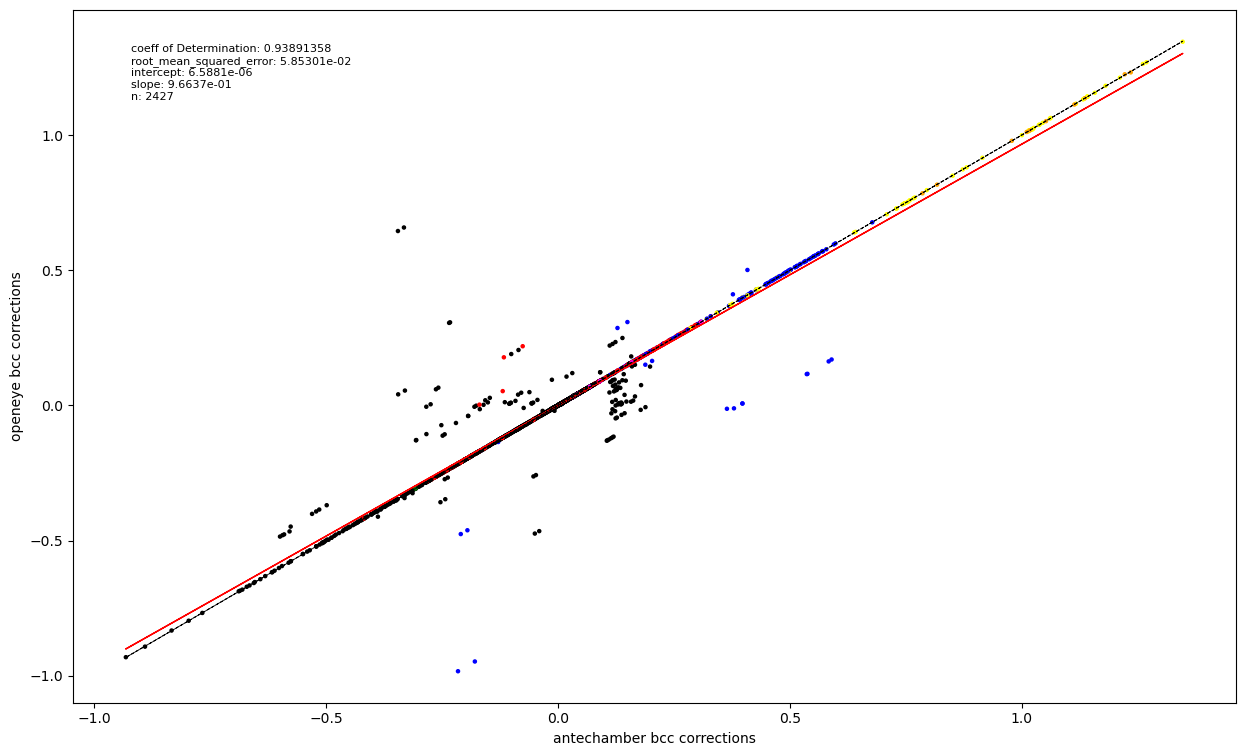

In [354]:
fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

df = oe_sql_confs[oe_sql_confs["conf_id"] == 0]
df = mols.merge(df, how="inner")
df = charge_methods_df.merge(df, how="inner", on=['name', 'conf_id'])
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
# subtracting bcc charges from am1 charges for each set
openeye_bccs = []
antechamber_bccs = []
for openeye_am1_charges, openeye_bcc_charges in zip(df['am1_oe_charges_nosym_noopt'], df['openeye_charges']):
    diff = [(bcc - am1) for bcc, am1 in zip(openeye_am1_charges, openeye_bcc_charges)]
    openeye_bccs.append(diff)
for antechamber_am1_charges, antechamber_bcc_charges in zip(df['am1_ante_charges'], df['ante_charges']):
    diff = [(bcc - am1) for bcc, am1 in zip(antechamber_am1_charges, antechamber_bcc_charges)]
    antechamber_bccs.append(diff)

troublesome_mols = scatter_charges(axs, openeye_bccs, antechamber_bccs, atoms, names, verbose=False, alpha=1)
axs.set(xlabel="antechamber bcc corrections", ylabel="openeye bcc corrections")
axs.label_outer()

In [353]:
df.head()

,conf_id,name,am1_oe_charges_nosym_noopt,am1_oe_charges_noopt,am1_ante_charges,diff_nosym_noopt,diff_noopt,molecule,id,openeye_charges,ante_charges
0,0,DrugBank_5354,"[-0.13347391784191132, -0.12001519650220871, -...","[-0.13346000015735626, -0.12031999975442886, -...","[-0.133, -0.12, -0.121, -0.096, -0.151, -0.14,...",0.000005,0.004816,Molecule with name 'DrugBank_5354' and SMILES ...,1,"[-0.14232000708580017, -0.11049000173807144, -...","[-0.142, -0.1105, -0.1105, -0.11, -0.144, -0.1..."
1,0,DrugBank_2800,"[-0.14122235774993896, -0.10029563307762146, -...","[-0.14121000468730927, -0.10029000043869019, -...","[-0.141, -0.1, -0.06, -0.089, -0.042, -0.291, ...",0.000008,0.002460,Molecule with name 'DrugBank_2800' and SMILES ...,401,"[-0.12581999599933624, -0.12152999639511108, -...","[-0.126, -0.121, -0.079, -0.088, 0.0994, -0.07..."
2,0,DrugBank_5387,"[-0.11458011716604233, -0.11780960112810135, -...","[-0.11781000345945358, -0.11753000319004059, -...","[-0.115, -0.118, -0.12, -0.118, -0.122, -0.131...",0.000008,0.012150,Molecule with name 'DrugBank_5387' and SMILES ...,485,"[-0.11731000244617462, -0.11709000170230865, -...","[-0.117, -0.117, -0.117, -0.117, -0.12425, -0...."
3,0,DrugBank_2824,"[-0.07689736038446426, -0.06210957467556, -0.1...","[-0.0768899992108345, -0.06210000067949295, -0...","[-0.077, -0.062, -0.169, -0.178, -0.175, -0.17...",0.000010,0.003361,Molecule with name 'DrugBank_2824' and SMILES ...,546,"[-0.08859000355005264, -0.09459000080823898, -...","[-0.089, -0.095, -0.177, -0.178, -0.166, -0.15..."
4,0,DrugBank_5407,"[-0.13023461401462555, -0.09256523102521896, -...","[-0.13021999597549438, -0.09256000071763992, -...","[-0.13, -0.093, -0.068, -0.164, -0.193, -0.135...",0.000006,0.001280,Molecule with name 'DrugBank_5407' and SMILES ...,946,"[-0.14169000089168549, -0.09049999713897705, -...","[-0.141, -0.091, -0.091, -0.196, -0.196, -0.15..."


# Summary of Charge Assignment
For some reason, antechamber and openeye are disagreeing somewhat in symmetry decisions and disagreeing largely when assigning BCCs. I can dig into this deeper, but for now I think it best to move forward with just using non-symmetrized am1-muliken charges to settle the ELF1 conformer selection issue. I have (and if I haven't by the time I am saying this... I will) put together a minimal reproducing script for a few molecules to demonstrate the issue. Moving on for now

## Moving forward: Investigating ways to compare openeye and antechamber charges 
Now that we have some metric that is more internally consistent (as in, both toolkits will have the same non-symmetrized am1-muliken charges if they are given the same conformer), we can use partial charges to again compare conformers. Overall, we are looking for two algorithm to get two very similar conformers: one from a set of rdkit generated conformers, the other from a set of openeye generated conformers. 

In [2]:
engine = create_engine("sqlite:///big_database.db")
Session = sessionmaker(bind=engine) # define a session to work on the engine we just made
session = Session()

query = session.query(RDKitConformers.id,
                       RDKitConformers.conf_id,
                       RDKitConformers.name,
                       RDKitConformers.openeye_charges,
                       RDKitConformers.ante_charges,
                       RDKitConformers.conformer,
                       RDKitConformers.oe_selected,
                       RDKitConformers.rd_selected)
rd_sql_confs = pd.read_sql(query.statement, engine)

query = session.query(OpenEyeConformers.id,
                       OpenEyeConformers.conf_id,
                       OpenEyeConformers.name,
                       OpenEyeConformers.openeye_charges,
                       OpenEyeConformers.ante_charges,
                       OpenEyeConformers.conformer,
                       OpenEyeConformers.oe_selected,
                       OpenEyeConformers.rd_selected)
oe_sql_confs = pd.read_sql(query.statement, engine)

session.close()
engine.dispose()

len(oe_sql_confs)

4893

In [3]:
engine = create_engine("sqlite:///am1_charges_database.db")
Session = sessionmaker(bind=engine) # define a session to work on the engine we just made
session = Session()

query = session.query(Molecules.name, Molecules.molecule)
mols = pd.read_sql(query.statement, engine)

session.close()
engine.dispose()
len(mols)

101

## Sanity Check: Do the methods give the same partial charges to the same conformers (Yes! finally) 

A total of 0 troublesome mols were found


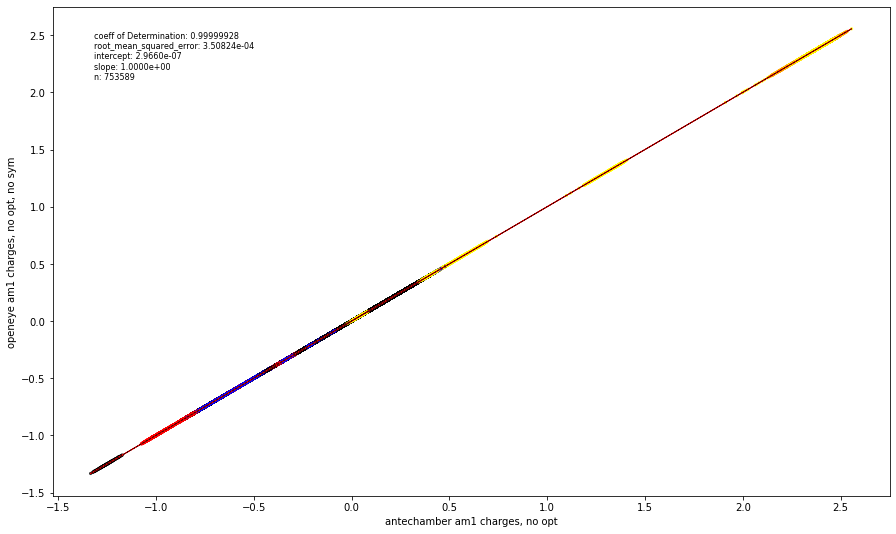

In [8]:
fig = plt.figure(figsize=(15,9))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

df = rd_sql_confs
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
troublesome_mols = scatter_charges(axs, df['openeye_charges'], df['ante_charges'], atoms, names)
axs.set(xlabel="antechamber am1 charges, no opt", ylabel="openeye am1 charges, no opt, no sym")
axs.label_outer()

# 

## Doing the Same "Random conformers vs ELF1 selected conformers" test as before

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A total of 19 troublesome mols were found
atoms with significant deviations in DrugBank_5451 -> {16}
atoms with significant deviations in DrugBank_3028 -> {16}
atoms with significant deviations in DrugBank_2982 -> {16}
atoms with significant deviations in DrugBank_700 -> {16}
atoms with significant deviations in DrugBank_3430 -> {6}
atoms with significant deviations in DrugBank_5847 -> {16, 7}
atoms with significant deviations in DrugBank_104 -> {16}
atoms with significant deviations in DrugBank_5514 -> {16}
atoms with significant deviations in DrugBank_2824 -> {16}
atoms with significant deviations in DrugBank_3278 -> {8, 1, 6, 7}
atoms with significant deviations in DrugBank_3332 -> {15}
atoms with significant deviations in DrugBank_5387 -> {16, 7}
atoms with significant deviations in DrugBank_810 -> {16}
atoms with significant deviations in DrugBank_3117 -> {8, 7}
atoms with significant deviations in DrugBank_5523 -> {6}
atoms with significant deviations in DrugBank_3088 -> {7}
atom

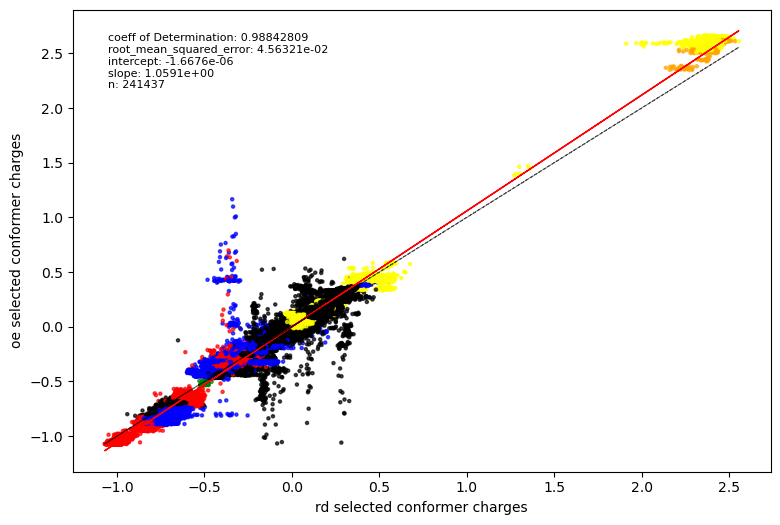

In [52]:
random_confs = pd.merge(rd_sql_confs, oe_sql_confs, how="left", left_on=['name', 'conf_id'], right_on=['name', 'conf_id'])
random_confs.dropna(inplace=True)
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)


df = random_confs
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
confs = df['conf_id']
confs = [[conf_id] * n for conf_id,n in zip(confs, n_atoms)]
scatter_charges(axs, random_confs['ante_charges_x'], random_confs['ante_charges_y'], atoms, names, confs, True, 0.7, -1, 0.30)
axs.set(xlabel="rd selected conformer charges", ylabel="oe selected conformer charges")
axs.label_outer()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A total of 0 troublesome mols were found


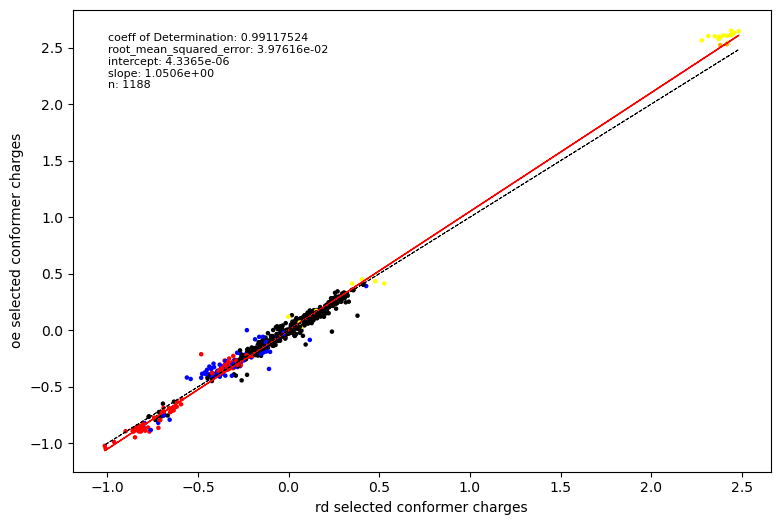

In [49]:
random_confs = pd.merge(rd_sql_confs, oe_sql_confs, how="left", left_on=['name', 'conf_id'], right_on=['name', 'conf_id'])
random_confs = random_confs[random_confs['oe_selected_x']==True]
random_confs.dropna(inplace=True)
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)


df = random_confs
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
confs = df['conf_id']
confs = [[conf_id] * n for conf_id,n in zip(confs, n_atoms)]
scatter_charges(axs, random_confs['ante_charges_x'], random_confs['ante_charges_y'], atoms, names, confs, True, 1, -1, 0.30)
axs.set(xlabel="rd selected conformer charges", ylabel="oe selected conformer charges")
axs.label_outer()

## Random Other tangent: charge-weighted RMSE
I figured at some point it would be useful to take the RMSE matrix and weight each atom with the absolute value of its charge. Maybe this can be useful to see how these molecules are different especially where the position of highly charged subgroups are concerned. The following blocks develop the functionality for this. 

In [11]:
def weighted_rmse(off_molecule, conf1, conf2, weights=[]):
    # takes the RMSE between conf1 and conf2. If "weight_on" is specified and valid, the function
    # will weight the RMSE with the given atom properties (like charge, weight, etc.)
    combined_mol = deepcopy(off_molecule)
    combined_mol._conformers = [conf1, conf2]
    if not weights: # if no weight specified
        try:
            rdkit_type = combined_mol.to_rdkit()
            # GetBestRMS
            rmse = AllChem.GetConformerRMS(rdkit_type, 0 ,1)
        except Exception:
            rmse = -1.0
    elif weights: # if provided with weights
        try:
            rdkit_type = combined_mol.to_rdkit()
            Chem.rdMolAlign.AlignMolConformers(rdkit_type)
            new_conf1 = []
            new_conf2 = []
            for pos in rdkit_type.GetConformers()[0].GetPositions():
                new_conf1.append(pos)
            for pos in rdkit_type.GetConformers()[1].GetPositions():
                new_conf2.append(pos)
            conf1_array = np.array(new_conf1)
            conf2_array = np.array(new_conf2)
            conf1._value = conf1_array
            conf2._value = conf2_array
            diff = np.square(conf1 - conf2)
            a, b = diff.shape
            diff = np.sum(diff, axis=1)
            weighted = np.multiply(diff, np.array(weights))
            summ = np.sum(weighted)
            rmse = sqrt(summ / a)
        except Exception:
            rmse = -1.0
    else:
        print("no valid weight specified")
    return rmse

In [345]:
mol = df.iloc[0, 1]
conf1 = df.iloc[0, 6]
conf2 = df.iloc[0, 12]
charges = df.iloc[0, 4]
charges = [abs(x*2) for x in charges]
rmse = weighted_rmse(mol, conf1, conf2, charges)
rmse

2.636311654884302

In [346]:
mol = df.iloc[0, 1]
conf1 = df.iloc[0, 6]
conf2 = df.iloc[0, 12]
rmse = weighted_rmse(mol, conf1, conf2)
combined_mol = deepcopy(mol)
combined_mol._conformers = [conf1, conf2]

rdkit_type = combined_mol.to_rdkit()
Chem.rdMolAlign.AlignMolConformers(rdkit_type)
new_conf1 = []
new_conf2 = []
for pos in rdkit_type.GetConformers()[0].GetPositions():
    new_conf1.append(pos)
for pos in rdkit_type.GetConformers()[1].GetPositions():
    new_conf2.append(pos)
conf1_array = np.array(new_conf1)
conf2_array = np.array(new_conf2)
conf1._value = conf1_array
conf2._value = conf2_array
diff = np.square(conf1 - conf2)
summ = np.sum(diff)
a, b = diff.shape
rmse = sqrt(summ / a)

## return to the RMSE plots
As a random tangent, do we see that RMSE's are correlated with different partial charges? 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

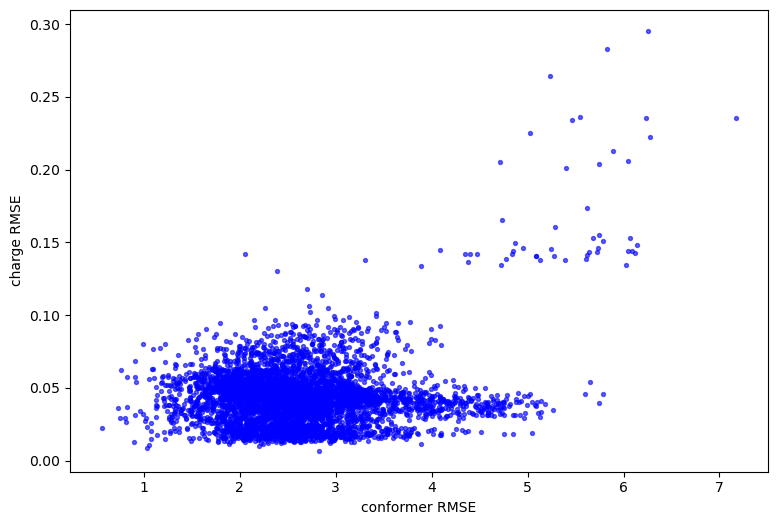

In [12]:
%matplotlib widget
random_confs = pd.merge(rd_sql_confs, oe_sql_confs, how="left", left_on=['name', 'conf_id'], right_on=['name', 'conf_id'])
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axis = gs.subplots(sharex=True, sharey=True)

dframe = mols.merge(random_confs, how="inner")
dframe.dropna(inplace=True)
x = []
y = []
col = []
for name, row in dframe.iterrows():
#     openeye_row = dframe[(dframe['name'] == row['name']) & (dframe['oe_selected'] == True)].iloc[0, :]
#     openeye_charges = openeye_row['oe_charges']
#     method1 = row['ante_charges']

#     diff1 = [(i1 - i2) for i1, i2 in zip(method1, openeye_charges)]
#     n = len(diff1)
#     x.append(row['rmse'])
#     y.append(sqrt(sum(l*l for l in diff1)/n))
    # find charge RMSE and append to y
    charges1 = row['ante_charges_x']
    charges2 = row['ante_charges_y']
    n = len(charges1)
    diff = [(i1 - i2) for i1, i2 in zip(charges1, charges2)]
    y.append(sqrt(sum(c*c for c in diff)/n))
    # find the molecular RMSE
    conf1 = row['conformer_x']
    conf2 = row['conformer_y']
    mol = row['molecule']
    rmse = weighted_rmse(mol, conf1, conf2)
    x.append(rmse)
    if row['oe_selected_y'] == True:
        col.append('blue')
    else:
        col.append('blue')

for i in range(len(x)):
    axis.scatter(x[i], y[i], c=col[i], s=8, alpha=0.6)

axis.set(xlabel="conformer RMSE", ylabel="charge RMSE")
# axis.set_ylim(top=0.2)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

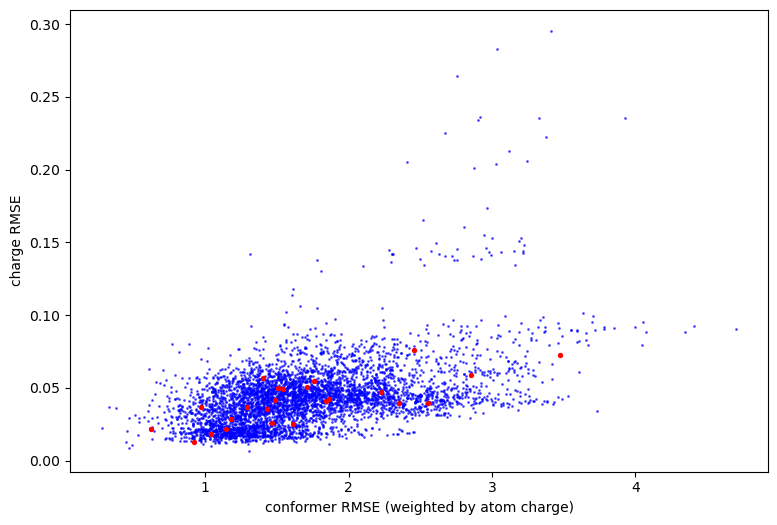

In [53]:
%matplotlib widget
random_confs = pd.merge(rd_sql_confs, oe_sql_confs, how="left", left_on=['name', 'conf_id'], right_on=['name', 'conf_id'])
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axis = gs.subplots(sharex=True, sharey=True)

dframe = mols.merge(random_confs, how="inner")
dframe.dropna(inplace=True)
x = []
y = []
col = []
for name, row in dframe.iterrows():
#     openeye_row = dframe[(dframe['name'] == row['name']) & (dframe['oe_selected'] == True)].iloc[0, :]
#     openeye_charges = openeye_row['oe_charges']
#     method1 = row['ante_charges']

#     diff1 = [(i1 - i2) for i1, i2 in zip(method1, openeye_charges)]
#     n = len(diff1)
#     x.append(row['rmse'])
#     y.append(sqrt(sum(l*l for l in diff1)/n))
    # find charge RMSE and append to y
    charges1 = row['ante_charges_x']
    charges2 = row['ante_charges_y']
    n = len(charges1)
    diff = [(i1 - i2) for i1, i2 in zip(charges1, charges2)]
    y.append(sqrt(sum(c*c for c in diff)/n))
    # find the molecular RMSE
    conf1 = row['conformer_x']
    conf2 = row['conformer_y']
    mol = row['molecule']
    charges = [abs(x*2) for x in charges1]
    rmse = weighted_rmse(mol, conf1, conf2, charges)
    x.append(rmse)
    if row['oe_selected_y'] == True:
        col.append('blue')
    else:
        col.append('blue')

for i in range(len(x)):
    axis.scatter(x[i], y[i], c=col[i], s=1, alpha=0.6)

axis.set(xlabel="conformer RMSE (weighted by atom charge)", ylabel="charge RMSE")
# axis.set_ylim(top=0.2)

x = []
y = []
for name, row in dframe.iterrows():
    if row['rd_selected_x'] == False:
        continue
    charges1 = row['ante_charges_x']
    # find charges from openeye that were selected using that algorithm
    try:
        openeye_row = dframe[(dframe['name'] == row['name']) & (dframe['oe_selected_x'] == True)].iloc[0, :]
    except Exception:
        continue
    charges2 = openeye_row['ante_charges_y']
    n = len(charges1)
    diff = [(i1 - i2) for i1, i2 in zip(charges1, charges2)]
    y.append(sqrt(sum(c*c for c in diff)/n))
    # find the molecular RMSE
    conf1 = row['conformer_x']
    conf2 = openeye_row['conformer_y']
    mol = row['molecule']
    charges = [abs(x*2) for x in charges1]
    rmse = weighted_rmse(mol, conf1, conf2, charges)
    x.append(rmse)
    
for i in range(len(x)):
    axis.scatter(x[i], y[i], s=8, alpha=1, c="red")
# axis.set_ylim(top=0.2)
plt.show()


In [309]:
%matplotlib widget
# random_confs = pd.merge(rd_sql_confs, oe_sql_confs, how="left", left_on=['name', 'conf_id'], right_on=['name', 'conf_id'])
# fig = plt.figure(figsize=(9,6))
# gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
# axis = gs.subplots(sharex=True, sharey=True)



In [301]:
for i in range(len(x)):
    print(col[i])

IndexError: list index out of range

In [315]:
dframe.iloc[0:50, :]

,name,molecule,id_x,conf_id,openeye_charges_x,ante_charges_x,conformer_x,oe_selected_x,rd_selected_x,id_y,openeye_charges_y,ante_charges_y,conformer_y,oe_selected_y,rd_selected_y
0,DrugBank_5354,Molecule with name 'DrugBank_5354' and SMILES ...,1,0,"[-0.13347391784191132, -0.12001519650220871, -...","[-0.133, -0.12, -0.121, -0.096, -0.151, -0.14,...","[[-7.341928613452989 A, 0.28578349686496135 A,...",False,False,1.0,"[-0.14233183860778809, -0.11179519444704056, -...","[-0.142, -0.112, -0.109, -0.11, -0.144, -0.168...","[[-3.991472639056279 A, 2.0039181812732023 A, ...",False,False
1,DrugBank_5354,Molecule with name 'DrugBank_5354' and SMILES ...,2,1,"[-0.13649313151836395, -0.12483531981706619, -...","[-0.136, -0.125, -0.115, -0.096, -0.163, -0.13...","[[6.768394689594231 A, 1.0695851429823626 A, -...",False,False,2.0,"[-0.14566269516944885, -0.10244523733854294, -...","[-0.145, -0.103, -0.115, -0.109, -0.14, -0.163...","[[4.213709699775822 A, 1.0894304294093238 A, -...",False,False
2,DrugBank_5354,Molecule with name 'DrugBank_5354' and SMILES ...,3,2,"[-0.12863250076770782, -0.11921760439872742, -...","[-0.129, -0.119, -0.117, -0.092, -0.154, -0.13...","[[7.080950768786466 A, -1.2110943436957187 A, ...",False,False,3.0,"[-0.14933457970619202, -0.10543710738420486, -...","[-0.149, -0.105, -0.115, -0.108, -0.137, -0.16...","[[3.937090833268494 A, -1.6368901659847523 A, ...",False,False
3,DrugBank_5354,Molecule with name 'DrugBank_5354' and SMILES ...,4,3,"[-0.13033583760261536, -0.12015973776578903, -...","[-0.13, -0.12, -0.116, -0.088, -0.148, -0.139,...","[[7.203941683602337 A, 0.5691308679648218 A, 0...",False,False,4.0,"[-0.14405855536460876, -0.11864733695983887, -...","[-0.144, -0.119, -0.109, -0.106, -0.135, -0.17...","[[3.007561197013603 A, 1.7680498098010964 A, 2...",False,False
4,DrugBank_5354,Molecule with name 'DrugBank_5354' and SMILES ...,5,4,"[-0.13518647849559784, -0.12223056703805923, -...","[-0.135, -0.122, -0.114, -0.106, -0.13, -0.142...","[[6.499313886789953 A, 0.5157051254096844 A, -...",False,False,5.0,"[-0.14616933465003967, -0.11123847961425781, -...","[-0.146, -0.111, -0.111, -0.109, -0.14, -0.169...","[[4.2927021985213845 A, 0.49623218659182694 A,...",False,False
5,DrugBank_5354,Molecule with name 'DrugBank_5354' and SMILES ...,6,5,"[-0.12889017164707184, -0.11955203860998154, -...","[-0.129, -0.12, -0.113, -0.121, -0.131, -0.144...","[[-5.150630051817931 A, 2.240894326895276 A, -...",False,False,6.0,"[-0.14313755929470062, -0.10912155359983444, -...","[-0.143, -0.109, -0.11, -0.11, -0.144, -0.169,...","[[-5.2093636322188805 A, 1.7831526187539797 A,...",False,False
6,DrugBank_5354,Molecule with name 'DrugBank_5354' and SMILES ...,7,6,"[-0.15401510894298553, -0.09289542585611343, -...","[-0.154, -0.093, -0.096, -0.117, -0.133, -0.15...","[[6.721553730901288 A, -0.9139353240405951 A, ...",False,False,7.0,"[-0.14495450258255005, -0.10918881744146347, -...","[-0.145, -0.109, -0.112, -0.109, -0.14, -0.168...","[[5.6602264735603995 A, -2.0111276720383087 A,...",False,False
7,DrugBank_5354,Molecule with name 'DrugBank_5354' and SMILES ...,8,7,"[-0.12859930098056793, -0.11880761384963989, -...","[-0.129, -0.119, -0.117, -0.085, -0.16, -0.14,...","[[6.070205503125857 A, 1.758891730230974 A, -0...",False,False,8.0,"[-0.14662855863571167, -0.11120052635669708, -...","[-0.147, -0.111, -0.112, -0.109, -0.139, -0.17...","[[5.429665839903818 A, 2.4514961237460384 A, 0...",False,False
8,DrugBank_5354,Molecule with name 'DrugBank_5354' and SMILES ...,9,8,"[-0.12940599024295807, -0.10976859927177429, -...","[-0.129, -0.11, -0.124, -0.114, -0.131, -0.14,...","[[6.05263456204549 A, -1.420696217507576 A, 1....",False,False,9.0,"[-0.14694969356060028, -0.11056187003850937, -...","[-0.147, -0.111, -0.113, -0.108, -0.136, -0.16...","[[5.487634734114729 A, -1.0881083901298858 A, ...",False,False
9,DrugBank_5354,Molecule with name 'DrugBank_5354' and SMILES ...,10,9,"[-0.12620402872562408, -0.12137286365032196, -...","[-0.126

In [21]:
random_confs = pd.merge(rd_sql_confs, oe_sql_confs, how="left", left_on=['name', 'conf_id'], right_on=['name', 'conf_id'])
df = random_confs
df = mols.merge(df, how="inner")
atoms = [molecule.atoms for molecule in df['molecule']]
names = df['name']
m = df['molecule']
n_atoms = [mol.n_atoms for mol in m]
names = [[name] * n for name, n in zip(names, n_atoms)]
confs = df['conf_id']
confs = [[conf_id] * n for conf_id,n in zip(confs, n_atoms)]

In [22]:
confs

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2],
 [3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 [4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
 

In [2]:
engine = create_engine("sqlite:///conformer_elf_selection_database.db")
Session = sessionmaker(bind=engine) # define a session to work on the engine we just made
session = Session()

query = session.query(RDKitConformers.id,
                       RDKitConformers.conf_id,
                       RDKitConformers.name,
                       RDKitConformers.openeye_charges,
                       RDKitConformers.ante_charges,
                       RDKitConformers.conformer,
                       RDKitConformers.oe_selected,
                       RDKitConformers.rd_selected)
rd_sql_confs = pd.read_sql(query.statement, engine)

query = session.query(OpenEyeConformers.id,
                       OpenEyeConformers.conf_id,
                       OpenEyeConformers.name,
                       OpenEyeConformers.openeye_charges,
                       OpenEyeConformers.ante_charges,
                       OpenEyeConformers.conformer,
                       OpenEyeConformers.oe_selected,
                       OpenEyeConformers.rd_selected)
oe_sql_confs = pd.read_sql(query.statement, engine)

session.close()
engine.dispose()

len(oe_sql_confs)

54

In [4]:
rd_sql_confs.head()


,id,conf_id,name,openeye_charges,ante_charges,conformer,oe_selected,rd_selected
0,1,1,DrugBank_5354,0.031254,0.017540,0.181112,True,True
1,2,2,DrugBank_5354,0.040204,0.006336,0.181112,False,False
2,3,3,DrugBank_5354,0.038788,0.009108,0.181112,False,False
3,4,4,DrugBank_5354,0.029313,0.003681,0.181112,False,False
4,5,5,DrugBank_5354,0.066080,0.011685,0.181112,False,False
